In [1]:
import random
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from scipy import sparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
from sklearn.preprocessing import StandardScaler
from feature_selector import FeatureSelector

In [2]:
PATH = 'train.csv'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 666
seed_everything(SEED)

In [4]:
df = pd.read_csv(PATH)
print(df.shape)
df.head()

(1105, 1525)


,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0


In [5]:
print ('nan:',df.isna().sum().sum()) #check
print ('null:',df.isnull().sum().sum())
print ('target:\n',df.y.value_counts())

nan: 0
null: 0
target:
 1.0    790
0.0    315
Name: y, dtype: int64


Решаем задачу банирной классификации. Количество объектов одного класса в два раза больше другого, можем попробовать accuracy

Удалим сильно коррелирующие признаки с помощью FeatureSelector bhttps://github.com/WillKoehrsen/feature-selector, отскейлим и уберем константные

In [6]:
X = df.drop('y', axis = 1)
y = df.y

scaled = StandardScaler().fit_transform(X)
X =  pd.DataFrame(scaled, index=X.index, columns=X.columns)

fs = FeatureSelector(data = X, labels = y)
fs.identify_collinear(correlation_threshold = 0.9)

collinear_features = fs.ops['collinear']
X = X.drop(collinear_features, axis = 1)

X = X.loc[:, (df != df.iloc[0]).any()]

X.shape

794 features with a correlation magnitude greater than 0.90.



(1105, 602)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2,random_state=SEED,stratify=y)
X_train.shape, X_val.shape

((884, 602), (221, 602))

# Feature Selection

## Deep Feature Selection


### Staff

In [8]:
def compute_loss( true, prediction, weights,
                     lambda1=0, lambda2=0, alpha1=0, alpha2=0):
        
        l1w, l2w, n_w, l1net, l2net, n_net = [torch.tensor(0.).cuda()] * 6   
        weights = weights[true.data.view(-1).long()].view_as(true).cuda()
        loss = F.binary_cross_entropy(prediction, true, reduction='none')
        
        return loss.mean() + lambda1 * ((1 - lambda2) / 2 * l2w + lambda2 * l1w) + alpha1 * (
            (1 - lambda2) / 2 * l2net + lambda2 * l1net)

def data_loader(X, y, batchsize, shuffle=True):
    X = X.values
    indices = np.arange(len(X))
    y = y.values
    if shuffle:
        indices = np.random.permutation(indices)
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield torch.FloatTensor(X[ix]), torch.FloatTensor(y[ix])

        
class Weight_Layer(nn.Module):
    def __init__(self, size):
        super(Weight_Layer, self).__init__()
        self.weights = nn.Parameter(torch.ones(size, requires_grad=True))    
    def forward(self, x):
        return x * self.weights
      
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Model

In [14]:
in_features = X.shape[1]
weighting = Weight_Layer(in_features)

DFS_Net = nn.Sequential(
            weighting, 
            nn.Linear(in_features, 16),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(16, 4), 
            nn.BatchNorm1d(4),
            nn.Dropout(0.25),
            nn.ReLU(inplace=True),
            nn.Linear(4, 1),
            nn.Sigmoid() 
         )
DFS_Net.apply(init_weights)

model = DFS_Net
model.cuda()

Sequential(
  (0): Weight_Layer()
  (1): Linear(in_features=602, out_features=16, bias=True)
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5)
  (4): ReLU(inplace)
  (5): Linear(in_features=16, out_features=4, bias=True)
  (6): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25)
  (8): ReLU(inplace)
  (9): Linear(in_features=4, out_features=1, bias=True)
  (10): Sigmoid()
)

### Training

best_epoch 298
best_loss 0.3817


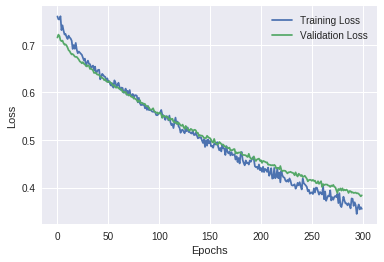

In [15]:
lambda1=2
lambda2=1
alpha1=0
alpha2=0

num_epoch=300
batchsize=32

abs_coefs = []


opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 50, eta_min=1e-8)


weights = torch.tensor([y_train.size - y_train.sum() / y_train.size,
             y_train.sum() / y_train.size]
        )

train_losses, val_losses = [], []
best_loss = (float('inf'))
best_epoch = -1
best_weights = model.state_dict()

for epoch_i in range(num_epoch):
  
    train_loss = train_batches = 0
    model.train(True)
    for X_batch, y_batch in data_loader(X_train, y_train, batchsize):
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda().view(-1,1)
        prediction = model(X_batch)

        loss = compute_loss(y_batch, prediction, weights,
                             lambda1, lambda2, alpha1, alpha2)
        loss.backward()
        opt.step()
        scheduler.step()
        opt.zero_grad()
        train_loss += loss.detach().data.cpu().numpy()
        train_batches += 1

    train_losses.append(train_loss / train_batches)
    val_loss = val_batches = 0
    model.train(False)
          
        
    for X_batch, y_batch in data_loader(X_val, y_val, batchsize, shuffle=False):
        X_batch = X_batch.detach().cuda()
        y_batch = y_batch.detach().cuda().view(-1,1)  
        prediction = model(X_batch)
        loss = compute_loss(y_batch, prediction, weights,
                             lambda1, lambda2, alpha1, alpha2)
        val_loss += loss.detach().data.cpu().numpy()
        val_batches += 1
        
    val_losses.append(val_loss / val_batches)

  #print("Epoch {} - train_avg_loss: {:.5f}  val_avg_loss: {:.5f}  lr: {:0.6f} ".format(
  #                epoch_i, (train_loss / train_batches), (val_loss / val_batches),
  #    scheduler.get_lr()[0]))
  
    if val_losses[-1] < best_loss:
        best_epoch = epoch_i
        best_loss = val_losses[-1]
        torch.save(model.state_dict(), 'weight_best.pt')
    
print('best_epoch', best_epoch)
print('best_loss', round(best_loss,4))


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [16]:
coefs = np.abs(next(iter(weighting.parameters())).detach().cpu().numpy())
feature_and_weight = sorted(zip(coefs, X.columns),
                                key=lambda x: abs(x[0]),reverse=True)
features_sorted = list(map(lambda x: x[1], feature_and_weight[-in_features:]))
num_tops = 20
tops = features_sorted [:num_tops]
X[tops].head()

,feature-1460,feature-458,feature-545,feature-868,feature-803,feature-796,feature-823,feature-1424,feature-1001,feature-789,feature-331,feature-1013,feature-998,feature-649,feature-937,feature-782,feature-815,feature-140,feature-943,feature-982
0,0.852490,-1.309345,-0.976275,-1.690036,4.954017e-15,0.0,-6.031806e-01,-0.18613,0.033677,0.041287,0.605184,-0.098200,-0.085397,-1.299448,-0.104422,-1.219663e-14,2.109088e-15,0.939610,-0.085397,-0.480117
1,0.852490,-1.366754,-2.068662,-1.165873,4.954017e-15,0.0,-2.971255e-01,-0.18613,-0.317004,-0.042577,-0.455531,-0.478424,-0.085397,0.769558,-0.104422,-1.219663e-14,2.109088e-15,-0.561244,-0.085397,-0.480117
2,3.606881,-1.309307,-0.538845,-1.935791,4.954017e-15,0.0,-6.020099e-01,-0.18613,0.762405,0.431334,1.083951,1.290963,-0.085397,-1.299448,-0.104422,-1.219663e-14,2.109088e-15,-0.005109,-0.085397,-0.480117
3,2.229686,-1.335437,0.444062,-1.916703,-5.700415e-01,0.0,-7.438807e-16,-0.18613,1.240767,0.136712,1.933193,-0.903208,-0.085397,-1.299448,-0.104422,-1.219663e-14,2.109088e-15,0.891202,-0.085397,-0.480117
4,-0.524705,-0.426017,-0.345892,0.363248,4.954017e-15,0.0,2.004399e+00,-0.18613,2.468606,1.224600,2.402267,1.875873,-0.085397,-1.299448,-0.104422,-1.219663e-14,2.109088e-15,0.423835,-0.085397,-0.480117


### Zero Importance Features
Находит фичи нулевой важности с помощью LightGBM

In [20]:
# Pass in the appropriate parameters

fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'accuracy', 
                            n_iterations = 10, 
                            early_stopping = False)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model


158 features with zero importance after one-hot encoding.



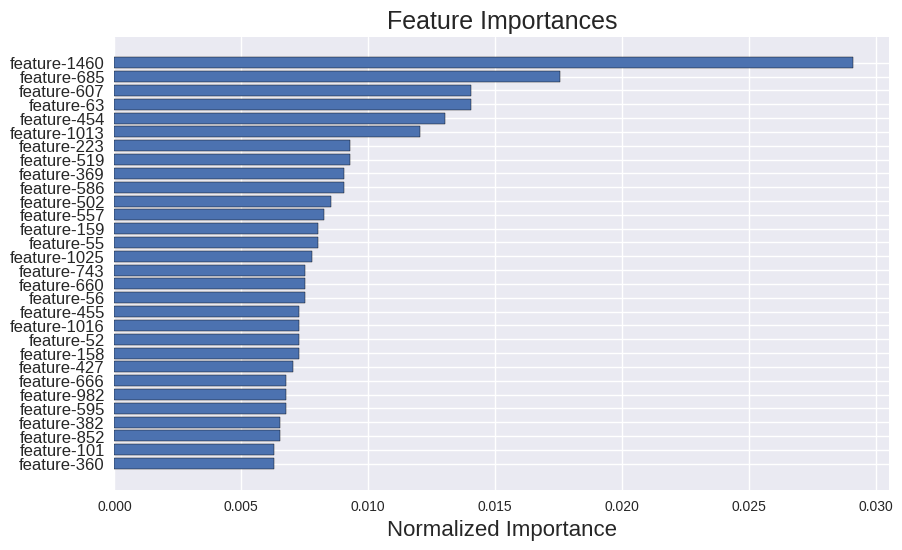

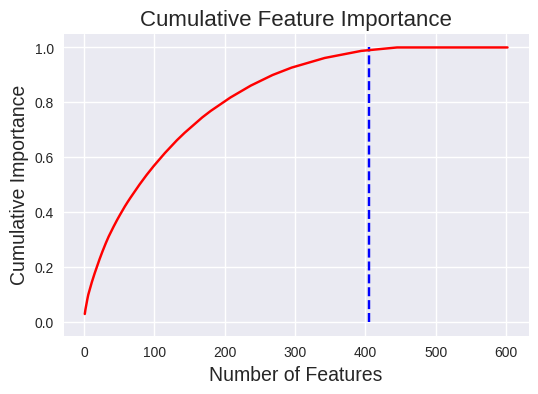

405 features required for 0.99 of cumulative importance


In [21]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 30)

### Low Importance Features

In [22]:
fs.identify_low_importance(cumulative_importance = 0.99)

404 features required for cumulative importance of 0.99 after one hot encoding.
198 features do not contribute to cumulative importance of 0.99.



### Removing Features

In [23]:
X_removed_FS = fs.remove(methods = 'all', keep_one_hot=False)

['zero_importance', 'low_importance'] methods have been run

Removed 198 features including one-hot features.


In [24]:
X_removed_FS.shape

(1105, 404)

# Final Models

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss

In [26]:
models = [
            'KNC',
            'SVC',
            'RFC',
         ]

clfs = [
        KNeighborsClassifier(n_jobs=-1),
        SVC(random_state=SEED, probability = True),
        RandomForestClassifier(random_state=SEED,n_jobs=-1),
        ]

params = {
            models[0]:{
                       'n_neighbors':[3, 5, 10], 
                       'weights':[ 'uniform', 'distance'],
                       'leaf_size':[10, 15, 30]
                      },
            models[1]:{
                       'C':[1, 10], 
                       'kernel':['rbf'],
                       'gamma':['auto']
                      },
            models[2]: {
                        'n_estimators':[50, 100, 150], 
                        'bootstrap': [True, False], 
                        'min_samples_split':[2, 5, 10],
                        'min_samples_leaf': [4]
                        },

         }

### Делаем прогон на топах DFS

In [27]:
def clf_test (n_x_train, n_x_val):
    y_test = 0
    clf_scores = []
    for name, estimator in zip(models,clfs):      
        print(name)
        clf = GridSearchCV(estimator, params[name], scoring='accuracy', refit='True', cv=5)
        clf.fit(n_x_train, y_train)
        print("best params: " + str(clf.best_params_))
        print("best scores: " + str(clf.best_score_))
        estimates = clf.predict_proba(n_x_val)
        y_test+=estimates
        acc = accuracy_score(y_val, clf.predict(n_x_val))
        print("Accuracy for test: {:.4%}".format(acc))
    clf_scores.append((acc))

In [28]:
num_tops = 400
tops = features_sorted [:num_tops]
print('num_tops: ', num_tops )
clf_test(X_train[tops],X_val[tops])

num_tops:  400
KNC
best params: {'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
best scores: 0.8823529411764706
Accuracy for test: 85.5204%
SVC
best params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
best scores: 0.8880090497737556
Accuracy for test: 86.4253%
RFC
best params: {'bootstrap': False, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
best scores: 0.8880090497737556
Accuracy for test: 88.6878%


### на топах lightGBM

In [ ]:
X_removed_FS_train, X_removed_FS_val, y_train, y_val = train_test_split(X_removed_FS, y,test_size=0.2,
                                                  random_state=SEED, stratify=y)

clf_test(X_removed_FS_train, X_removed_FS_val)

KNC
best params: {'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
best scores: 0.8699095022624435
Accuracy for test: 85.0679%
SVC
best params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
best scores: 0.8846153846153846
Accuracy for test: 87.3303%
RFC


# Вывод:
Оба метода отбора дают сравнимый по качеству результат на протестированных моделях классификации